In [1]:
import pandas as pd
import os

# List of all 9 uploaded file names
all_files = [
    "olist_customers_dataset.csv",
    "olist_geolocation_dataset.csv",
    "olist_order_items_dataset.csv",
    "olist_order_payments_dataset.csv",
    "olist_order_reviews_dataset.csv",
    "olist_orders_dataset.csv",
    "olist_products_dataset.csv",
    "olist_sellers_dataset.csv",
    "product_category_name_translation.csv"
]

print("--- Starting File Check ---")

all_ok = True
for filename in all_files:
    # 1. Check if the file exists in the current directory
    if not os.path.exists(filename):
        print(f"FAIL: File not found: '{filename}'")
        all_ok = False
        continue

    # 2. Try to read the file (first 5 rows only)
    try:
        df = pd.read_csv(filename, nrows=5)

        # 3. Print success and column headers
        print(f"SUCCESS: '{filename}' loaded correctly.")
        print(f"   Columns: {list(df.columns)}")
        print("-" * 20)

    except Exception as e:
        print(f"⚠️ ERROR: Could not read '{filename}'. Reason: {e}")
        all_ok = False
        print("-" * 20)

if all_ok:
    print("\All Files Verified! You are ready to start the cleaning script.")
else:
    print("\Check Failed. Please ensure all files are uploaded and named correctly.")

--- Starting File Check ---
✅ SUCCESS: 'olist_customers_dataset.csv' loaded correctly.
   Columns: ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
--------------------
✅ SUCCESS: 'olist_geolocation_dataset.csv' loaded correctly.
   Columns: ['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng', 'geolocation_city', 'geolocation_state']
--------------------
✅ SUCCESS: 'olist_order_items_dataset.csv' loaded correctly.
   Columns: ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
--------------------
✅ SUCCESS: 'olist_order_payments_dataset.csv' loaded correctly.
   Columns: ['order_id', 'payment_sequential', 'payment_type', 'payment_installments', 'payment_value']
--------------------
✅ SUCCESS: 'olist_order_reviews_dataset.csv' loaded correctly.
   Columns: ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_d

In [3]:
import pandas as pd
import os # Included for robustness, if you are still using the os.chdir method

# --- FILE LOADING ---

# Files we need for the cleaning and master data frame
files = {
    "orders": "olist_orders_dataset.csv",
    "items": "olist_order_items_dataset.csv",
    "products": "olist_products_dataset.csv",
    "translations": "product_category_name_translation.csv"
    # We will load reviews later when we need them
}

dfs = {} # <--- This is the line that defines 'dfs' and fixes your NameError
print("--- Loading Essential Files ---")

for key, filename in files.items():
    try:
        dfs[key] = pd.read_csv(filename)
        print(f"Loaded {filename}: {dfs[key].shape}")
    except FileNotFoundError:
        print(f"Error: Could not find {filename}.")

if not all(key in dfs for key in ['orders', 'items', 'products', 'translations']):
    print("\n[CRITICAL ERROR] Not all essential datasets were loaded. Please fix file access and try again.")
else:
    print("\nFile loading successful. Ready for Step 1.")

--- Loading Essential Files ---
Loaded olist_orders_dataset.csv: (99441, 8)
Loaded olist_order_items_dataset.csv: (112650, 7)
Loaded olist_products_dataset.csv: (32951, 9)
Loaded product_category_name_translation.csv: (71, 2)

File loading successful. Ready for Step 1.


In [4]:
# --- Step 1: Date Conversion & Category Translation ---

print("--- Starting Step 1: Date & Category Cleaning ---")

# A. Convert Date Columns to Datetime Objects in the Orders DataFrame
date_cols_orders = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]

for col in date_cols_orders:
    # pd.to_datetime handles the conversion, errors='coerce' turns bad data into NaT
    dfs['orders'][col] = pd.to_datetime(dfs['orders'][col], errors='coerce')

print(f"Orders DataFrame date columns converted to datetime.")


# B. Translate Product Categories to English
# 1. Merge products with the translation table
products_english = pd.merge(
    dfs['products'],
    dfs['translations'],
    on='product_category_name',
    how='left'
)

# 2. Handle Missing Translations: Fill missing English names with the Portuguese original.
products_english['product_category_name_english'] = products_english['product_category_name_english'].fillna(products_english['product_category_name'])
dfs['products_english'] = products_english # Store the new translated product data

print("Product categories translated and stored in 'dfs['products_english']'.")

print("\n--- Step 1 Complete ---")

--- Starting Step 1: Date & Category Cleaning ---
Orders DataFrame date columns converted to datetime.
Product categories translated and stored in 'dfs['products_english']'.

--- Step 1 Complete ---


In [5]:
# Assuming your 'dfs' dictionary has been updated by Step 1 and contains the necessary DataFrames.

print("--- Step 2: Starting Data Merging & Null Inspection ---")

# C. Create Master DataFrame
# Merge Orders -> Items (on order_id) -> Products (on product_id)
master_df = dfs['orders'].merge(dfs['items'], on='order_id', how='left')
master_df = master_df.merge(dfs['products_english'], on='product_id', how='left')

print(f"Master DataFrame Created. Total Rows: {master_df.shape[0]}, Total Columns: {master_df.shape[1]}")

# D. Inspect Missing Values
# Calculate and display the percentage of missing values for each column
missing_values = master_df.isnull().sum()
missing_percent = (master_df.isnull().sum() / len(master_df)) * 100

missing_info = pd.DataFrame({
    'Total Missing': missing_values,
    'Percent Missing': missing_percent
})

# Filter to show only columns with missing data, sorted by percentage
missing_info = missing_info[missing_info['Total Missing'] > 0].sort_values(by='Percent Missing', ascending=False)

print("\n--- Master DataFrame Missing Value Summary ---")
print(missing_info)

# Store the master_df back into the dfs dictionary for later use
dfs['master'] = master_df

print("\n--- Step 2 Complete ---")

--- Step 2: Starting Data Merging & Null Inspection ---
Master DataFrame Created. Total Rows: 113425, Total Columns: 23

--- Master DataFrame Missing Value Summary ---
                               Total Missing  Percent Missing
order_delivered_customer_date           3229         2.846815
product_category_name                   2378         2.096540
product_category_name_english           2378         2.096540
product_photos_qty                      2378         2.096540
product_description_lenght              2378         2.096540
product_name_lenght                     2378         2.096540
order_delivered_carrier_date            1968         1.735067
product_height_cm                        793         0.699140
product_length_cm                        793         0.699140
product_weight_g                         793         0.699140
product_width_cm                         793         0.699140
order_item_id                            775         0.683271
freight_value             

In [6]:
# Assuming 'dfs['master']' exists from the previous step.
master_df = dfs['master'].copy()

print("--- Starting Step 3: Handling Missing Values ---")

# A. Drop Incomplete Transaction Rows (Core Item Data Missing)
# We drop any row where the main transaction details are missing (Price is a good proxy).
rows_before = master_df.shape[0]
master_df.dropna(subset=['price', 'product_id', 'seller_id', 'order_item_id'], inplace=True)
rows_after = master_df.shape[0]

print(f"Dropped {rows_before - rows_after} rows ({100 * (rows_before - rows_after) / rows_before:.2f}%) due to missing core transaction data (e.g., price or product ID).")


# B. Impute Product Category and Attribute Information

# 1. Fill missing English categories with a clear indicator 'unknown'
master_df['product_category_name_english'].fillna('unknown', inplace=True)

# 2. Fill missing numeric product attributes (lengths, weight, photos) with 0
# The missing 2.1% are the same rows, where the product data is unavailable.
product_numeric_cols = [
    'product_name_lenght',
    'product_description_lenght',
    'product_photos_qty',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm'
]
master_df[product_numeric_cols] = master_df[product_numeric_cols].fillna(0)


# C. Re-check Missing Values for Confirmation
print("\n--- Remaining Missing Value Check ---")
remaining_missing = master_df.isnull().sum()
remaining_percent = (master_df.isnull().sum() / len(master_df)) * 100

remaining_info = pd.DataFrame({
    'Total Missing': remaining_missing,
    'Percent Missing': remaining_percent
})

# Display only columns still having missing data
remaining_info = remaining_info[remaining_info['Total Missing'] > 0].sort_values(by='Percent Missing', ascending=False)

print(remaining_info)

# Update the master dataframe in the dfs dictionary
dfs['master'] = master_df

print("\n--- Step 3 Complete ---")

--- Starting Step 3: Handling Missing Values ---
Dropped 775 rows (0.68%) due to missing core transaction data (e.g., price or product ID).

--- Remaining Missing Value Check ---
                               Total Missing  Percent Missing
order_delivered_customer_date           2454         2.178429
product_category_name                   1603         1.422992
order_delivered_carrier_date            1194         1.059920
order_approved_at                         15         0.013316

--- Step 3 Complete ---


/tmp/ipython-input-1516606235.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  master_df['product_category_name_english'].fillna('unknown', inplace=True)


In [7]:
# Assuming 'dfs['master']' is the cleaned DataFrame from Step 3.
master_df = dfs['master'].copy()

print("--- Starting Step 4: Feature Engineering ---")

# A. Calculate Delivery Times

# 1. Delivery Speed (Actual Delivery Date - Purchase Date)
master_df['delivery_time_days'] = (
    master_df['order_delivered_customer_date'] - master_df['order_purchase_timestamp']
).dt.total_seconds() / (60*60*24) # Convert timedelta to days

# 2. Shipping Performance (Actual Delivery Date - Estimated Delivery Date)
# A negative number means delivery was earlier than estimated.
master_df['shipping_delta_days'] = (
    master_df['order_delivered_customer_date'] - master_df['order_estimated_delivery_date']
).dt.total_seconds() / (60*60*24)

print("Delivery metrics calculated: 'delivery_time_days' and 'shipping_delta_days'.")


# B. Time-Series Features (for plotting trends)

# Extract year-month for plotting monthly trends
master_df['order_month_year'] = master_df['order_purchase_timestamp'].dt.to_period('M')

# Extract day of the week (Monday=0, Sunday=6)
master_df['order_day_of_week'] = master_df['order_purchase_timestamp'].dt.dayofweek

print("Time-series features extracted: 'order_month_year' and 'order_day_of_week'.")


# C. Revenue per Order (Aggregation)
# The master_df currently has one row per item. For total revenue per order, we need to group.
order_revenue = master_df.groupby('order_id')['price'].sum().reset_index()
order_revenue.rename(columns={'price': 'total_order_revenue'}, inplace=True)

# Merge this total back into a unique list of orders (without item duplication)
orders_unique = master_df.drop_duplicates(subset=['order_id']).copy()
orders_unique = orders_unique.merge(order_revenue, on='order_id', how='left')

dfs['orders_unique'] = orders_unique # Store the unique orders dataset

print(f"Unique Orders DataFrame created for order-level analysis. Total Rows: {orders_unique.shape[0]}")

# Update the master dataframe in the dfs dictionary for item-level analysis
dfs['master'] = master_df

print("\n--- Step 4 Complete ---")

--- Starting Step 4: Feature Engineering ---
Delivery metrics calculated: 'delivery_time_days' and 'shipping_delta_days'.
Time-series features extracted: 'order_month_year' and 'order_day_of_week'.
Unique Orders DataFrame created for order-level analysis. Total Rows: 98666

--- Step 4 Complete ---


--- Starting Step 5: Analysis and Visualization ---


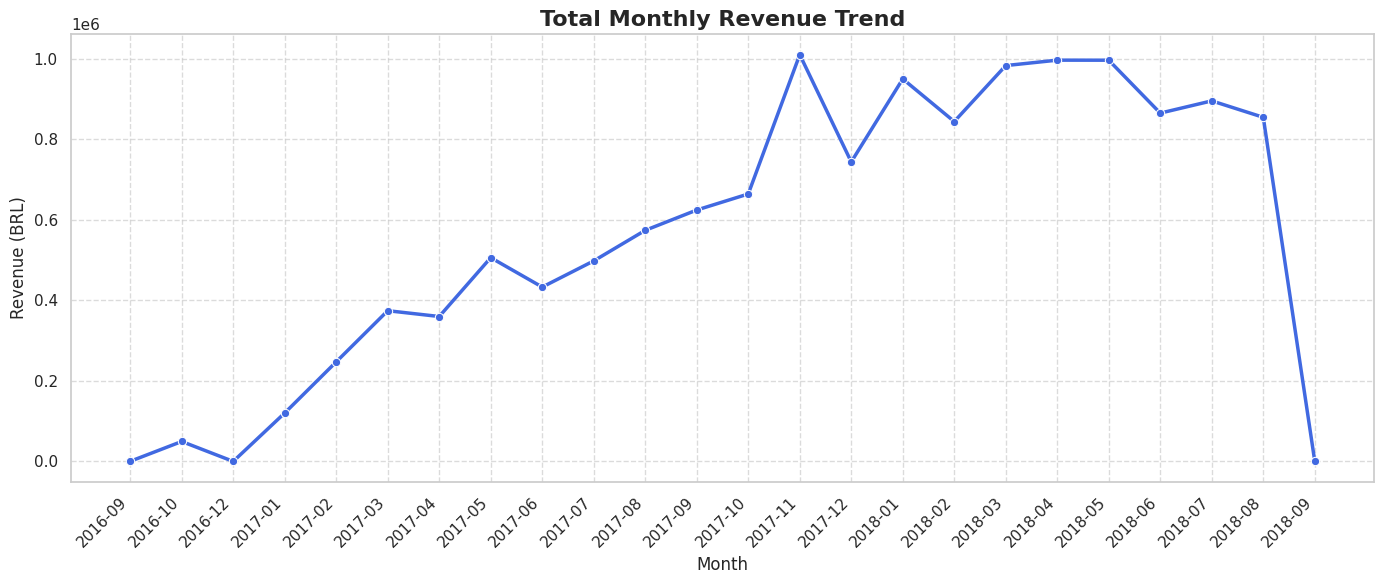

Visualization A: Monthly Sales Trend generated.


/tmp/ipython-input-1509849295.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories, x='price', y='product_category_name_english', palette='viridis')


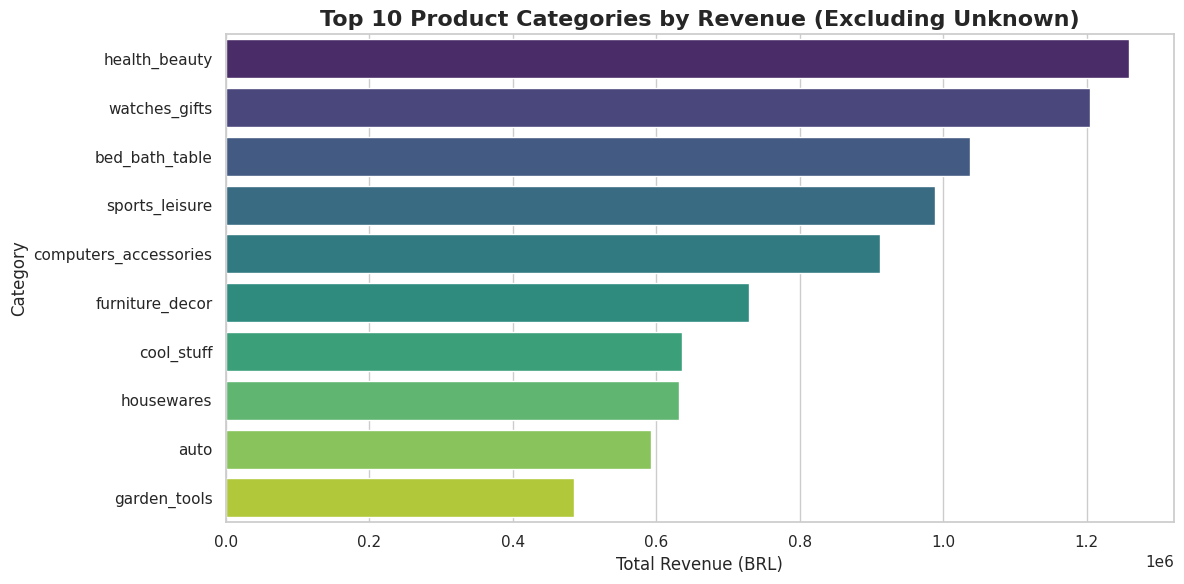

Visualization B: Top 10 Product Categories generated.


/tmp/ipython-input-1509849295.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=status_counts, x='status', y='count', palette='muted')


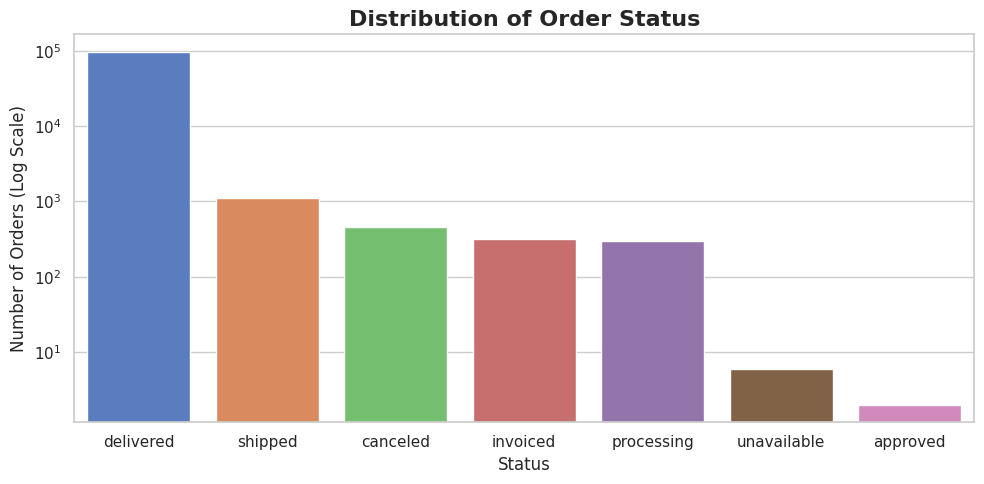

Visualization C: Order Status Distribution generated.

--- Step 5 Complete: All visualizations generated ---


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style for plots
sns.set(style="whitegrid", rc={"figure.figsize": (12, 6)})

# Assuming 'dfs['master']' and 'dfs['orders_unique']' exist from Step 4.

print("--- Starting Step 5: Analysis and Visualization ---")


# A. Monthly Sales Trend (Line Chart) - Using the item-level data
monthly_sales = master_df.groupby('order_month_year')['price'].sum().reset_index()
monthly_sales['order_month_year'] = monthly_sales['order_month_year'].astype(str)

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_sales, x='order_month_year', y='price', marker='o', color='royalblue', linewidth=2.5)
plt.title('Total Monthly Revenue Trend', fontsize=16, weight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Revenue (BRL)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("Visualization A: Monthly Sales Trend generated.")


# B. Top 10 Product Categories (Bar Chart) - Using the item-level data
# Exclude the 'unknown' category for this analysis
top_categories = master_df[master_df['product_category_name_english'] != 'unknown'].copy()
top_categories = top_categories.groupby('product_category_name_english')['price'].sum().sort_values(ascending=False).head(10).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_categories, x='price', y='product_category_name_english', palette='viridis')
plt.title('Top 10 Product Categories by Revenue (Excluding Unknown)', fontsize=16, weight='bold')
plt.xlabel('Total Revenue (BRL)', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()
print("Visualization B: Top 10 Product Categories generated.")


# C. Order Status Distribution (Bar Chart) - Using the unique order data
status_counts = dfs['orders_unique']['order_status'].value_counts().reset_index()
status_counts.columns = ['status', 'count']

plt.figure(figsize=(10, 5))
sns.barplot(data=status_counts, x='status', y='count', palette='muted')
plt.title('Distribution of Order Status', fontsize=16, weight='bold')
plt.xlabel('Status', fontsize=12)
plt.ylabel('Number of Orders (Log Scale)', fontsize=12)
plt.yscale('log') # Log scale helps visualize small counts (like 'canceled') vs huge counts (like 'delivered')
plt.tight_layout()
plt.show()
print("Visualization C: Order Status Distribution generated.")

print("\n--- Step 5 Complete: All visualizations generated ---")

In [9]:
# Assuming 'dfs' contains the loaded dataframes and 'dfs['master']' is the cleaned master dataframe.

print("--- Starting Step 6: Load, Clean, and Merge Reviews ---")

# A. Load and Clean Reviews Data
reviews_filename = "olist_order_reviews_dataset.csv"
try:
    dfs['reviews'] = pd.read_csv(reviews_filename)
    print(f"Loaded {reviews_filename}: {dfs['reviews'].shape}")

    # Convert date columns to datetime objects
    date_cols_reviews = ['review_creation_date', 'review_answer_timestamp']
    for col in date_cols_reviews:
        dfs['reviews'][col] = pd.to_datetime(dfs['reviews'][col], errors='coerce')

    print("Reviews date columns converted.")

except FileNotFoundError:
    print(f"[CRITICAL ERROR] Could not find {reviews_filename}. Please check file access.")


# B. Merge Reviews with the Master DataFrame
# Reviews are at the order level, but we merge into master_df to link them to specific items/categories.
master_df = dfs['master'].merge(
    dfs['reviews'][['order_id', 'review_score', 'review_creation_date']],
    on='order_id',
    how='left'
)

# C. Inspection and Summary
print(f"\nMaster DataFrame merged with Reviews. New shape: {master_df.shape}")

# Check the distribution of review scores
print("\nReview Score Distribution:")
print(master_df['review_score'].value_counts(dropna=False, normalize=True).mul(100).round(2).astype(str) + '%')

# Update the master dataframe in the dfs dictionary
dfs['master'] = master_df

print("\n--- Step 6: Review Load and Merge Complete ---")

--- Starting Step 6: Load, Clean, and Merge Reviews ---
Loaded olist_order_reviews_dataset.csv: (99224, 7)
Reviews date columns converted.

Master DataFrame merged with Reviews. New shape: (113314, 29)

Review Score Distribution:
review_score
5.0    56.06%
4.0    18.81%
1.0    12.56%
3.0     8.32%
2.0     3.42%
NaN     0.83%
Name: proportion, dtype: object

--- Step 6: Review Load and Merge Complete ---


--- Starting Step 6: Review Visualization ---


/tmp/ipython-input-1185907050.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_15_scores, x='review_score', y='product_category_name_english', palette='Spectral')


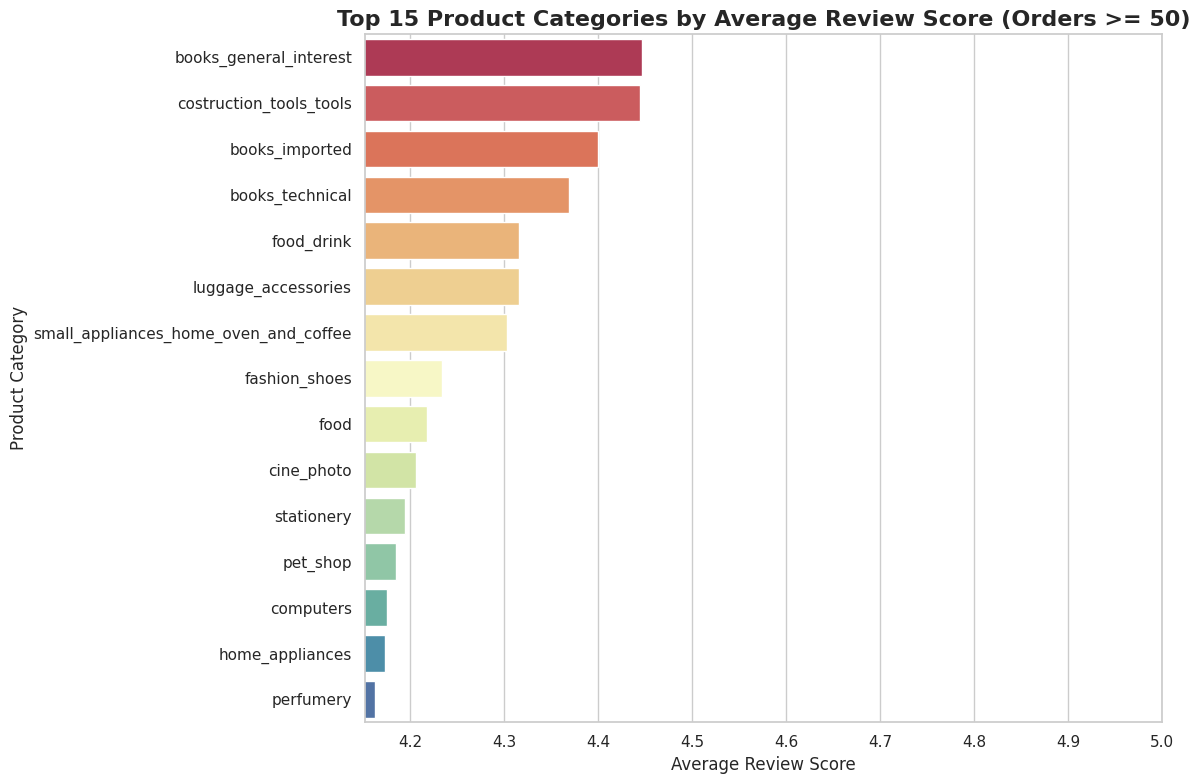


--- Step 6: Review Analysis Complete. ---


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'dfs['master']' is the merged DataFrame from Step 6 - Part A.
master_df = dfs['master'].copy()

print("--- Starting Step 6: Review Visualization ---")

# A. Average Review Score by Product Category

# 1. Calculate the average score for each product category
# Filter out the 'unknown' categories and group by the English category name
category_scores = master_df[master_df['product_category_name_english'] != 'unknown'].copy()

# Calculate the mean review score, rounded to 2 decimal places
category_scores = category_scores.groupby('product_category_name_english')['review_score'].mean().sort_values(ascending=False).reset_index()

# Filter for categories that have at least 50 orders to ensure reliable averages (optional but good practice)
category_counts = master_df.groupby('product_category_name_english')['order_id'].nunique()
reliable_categories = category_counts[category_counts >= 50].index

category_scores_reliable = category_scores[category_scores['product_category_name_english'].isin(reliable_categories)]

# Get the Top 15 categories by average score
top_15_scores = category_scores_reliable.head(15)


# 2. Visualization: Top 15 Categories by Average Review Score
plt.figure(figsize=(12, 8))
sns.barplot(data=top_15_scores, x='review_score', y='product_category_name_english', palette='Spectral')
plt.title('Top 15 Product Categories by Average Review Score (Orders >= 50)', fontsize=16, weight='bold')
plt.xlabel('Average Review Score', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.xlim(top_15_scores['review_score'].min() - 0.01, 5.0) # Set max x-axis to 5.0 for context
plt.tight_layout()
plt.show()


print("\n--- Step 6: Review Analysis Complete. ---")

In [11]:
# Assuming 'dfs' contains the loaded dataframes and 'dfs['master']' is the cleaned master dataframe.

print("--- Starting Step 7A: Load and Merge Seller and Payment Data ---")

# A. Load Seller Data and Payment Data
seller_filename = "olist_sellers_dataset.csv"
payments_filename = "olist_order_payments_dataset.csv"

try:
    dfs['sellers'] = pd.read_csv(seller_filename)
    print(f"Loaded {seller_filename}: {dfs['sellers'].shape}")
except FileNotFoundError:
    print(f"[CRITICAL ERROR] Could not find {seller_filename}. Please check file access.")

try:
    dfs['payments'] = pd.read_csv(payments_filename)
    print(f"Loaded {payments_filename}: {dfs['payments'].shape}")
except FileNotFoundError:
    print(f"[CRITICAL ERROR] Could not find {payments_filename}. Please check file access.")


# B. Merge Seller Data into Master DataFrame
# We merge on 'seller_id', which is present in our master_df (item level)
master_df = dfs['master'].merge(
    dfs['sellers'][['seller_id', 'seller_city', 'seller_state']],
    on='seller_id',
    how='left'
)
print(f"Master DataFrame merged with Sellers. New shape: {master_df.shape}")


# C. Inspect Missing Values in Seller Data
print("\nMissing values check after merging sellers:")
print(master_df[['seller_city', 'seller_state']].isnull().sum())

# Update the master dataframe in the dfs dictionary
dfs['master'] = master_df

print("\n--- Step 7A Complete ---")

--- Starting Step 7A: Load and Merge Seller and Payment Data ---
Loaded olist_sellers_dataset.csv: (3095, 4)
Loaded olist_order_payments_dataset.csv: (103886, 5)
Master DataFrame merged with Sellers. New shape: (113314, 31)

Missing values check after merging sellers:
seller_city     0
seller_state    0
dtype: int64

--- Step 7A Complete ---


--- Starting Step 7B: Seller Analysis and Visualization ---


/tmp/ipython-input-3943682971.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=seller_state_revenue, x='price', y='seller_state', palette='magma')


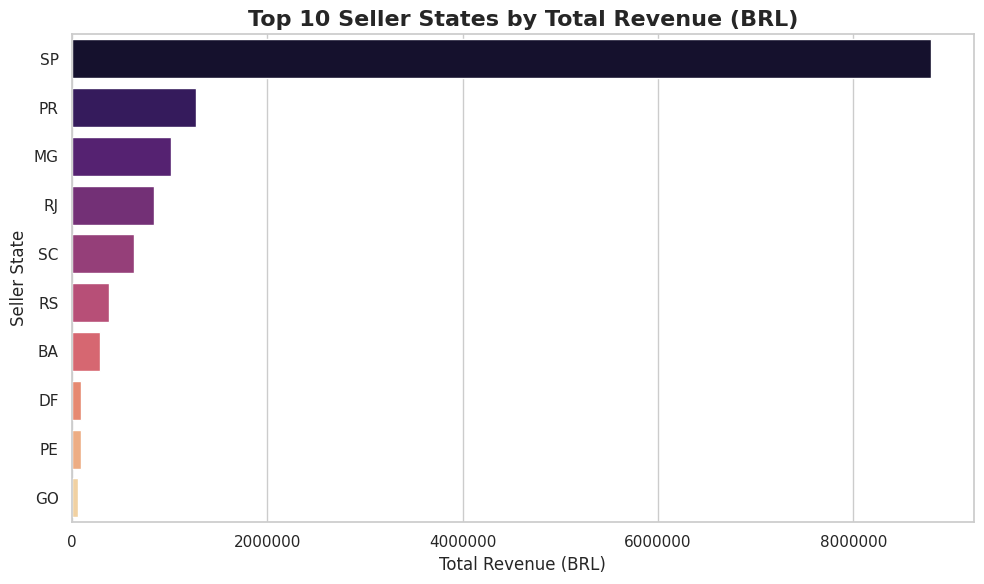

Visualization A: Top 10 Seller States by Revenue generated.


/tmp/ipython-input-3943682971.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_sellers_revenue, x='price', y='seller_label', palette='mako')


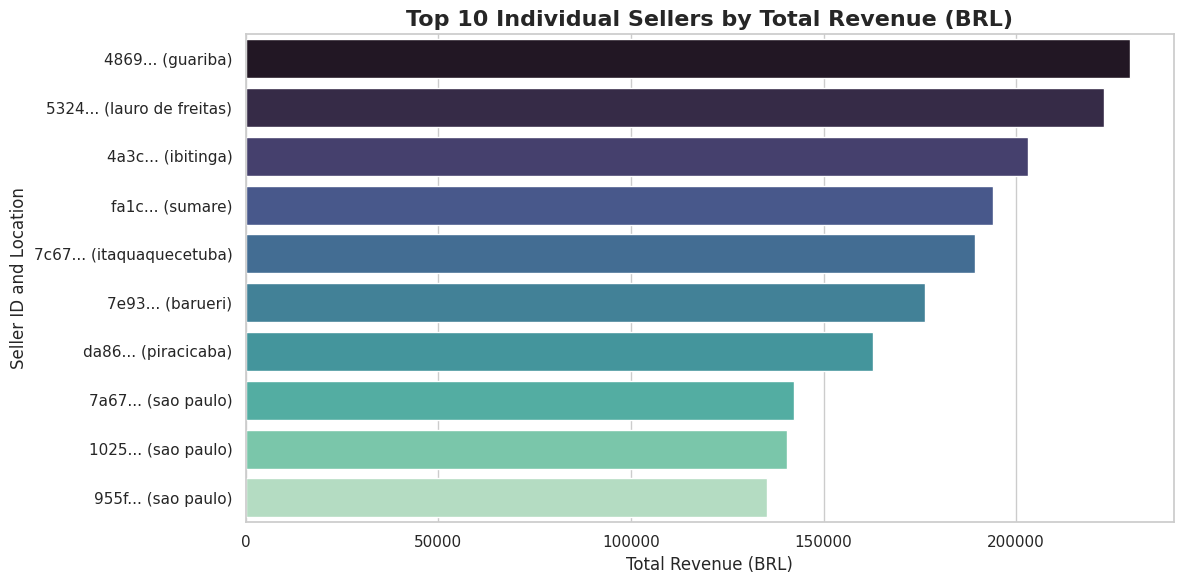

Visualization B: Top 10 Individual Sellers by Revenue generated.

--- Step 7B Complete: Seller Performance Analysis Finished ---


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'dfs['master']' is the merged DataFrame from Step 7A.
master_df = dfs['master'].copy()

print("--- Starting Step 7B: Seller Analysis and Visualization ---")

# --- A. Top 10 Seller States by Revenue ---

# Group by seller state and sum the price (revenue)
seller_state_revenue = master_df.groupby('seller_state')['price'].sum().sort_values(ascending=False).head(10).reset_index()

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=seller_state_revenue, x='price', y='seller_state', palette='magma')
plt.title('Top 10 Seller States by Total Revenue (BRL)', fontsize=16, weight='bold')
plt.xlabel('Total Revenue (BRL)', fontsize=12)
plt.ylabel('Seller State', fontsize=12)
plt.ticklabel_format(style='plain', axis='x') # Prevent scientific notation on x-axis
plt.tight_layout()
plt.show()
print("Visualization A: Top 10 Seller States by Revenue generated.")


# --- B. Top 10 Individual Sellers by Revenue ---

# Group by individual seller ID and sum the price (revenue)
top_sellers_revenue = master_df.groupby('seller_id')['price'].sum().sort_values(ascending=False).head(10).reset_index()

# Merge seller location data to make the chart more insightful
top_sellers_revenue = top_sellers_revenue.merge(
    master_df[['seller_id', 'seller_city']].drop_duplicates(),
    on='seller_id',
    how='left'
)

# Create a combined label for the chart: Seller ID + City
top_sellers_revenue['seller_label'] = top_sellers_revenue['seller_id'].str[:4] + '... (' + top_sellers_revenue['seller_city'] + ')'


# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(data=top_sellers_revenue, x='price', y='seller_label', palette='mako')
plt.title('Top 10 Individual Sellers by Total Revenue (BRL)', fontsize=16, weight='bold')
plt.xlabel('Total Revenue (BRL)', fontsize=12)
plt.ylabel('Seller ID and Location', fontsize=12)
plt.ticklabel_format(style='plain', axis='x')
plt.tight_layout()
plt.show()
print("Visualization B: Top 10 Individual Sellers by Revenue generated.")

print("\n--- Step 7B Complete: Seller Performance Analysis Finished ---")